Import required libraries

In [2]:
pip install osmnx

     |████████████████████████████████| 92 kB 41 kB/s  eta 0:00:01
     |████████████████████████████████| 17.1 MB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 817 kB/s eta 0:00:01
     |████████████████████████████████| 7.7 MB 860 kB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 224 kB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 16.6 MB 816 kB/s eta 0:00:01    |█████████████████▍              | 9.0 MB 1.2 MB/s eta 0:00:07
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: Rtree
    Found existing installation: Rtree 0.9.7
    Uninstalling Rtree-0.9.7:
      Successfully uninstalled Rtree-0.9.7
  Attempting uninstall:

In [1]:

import osmnx as ox
import networkx as nx
import queue
import math
import priority_dict

/home/farhan/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Import OSM map of VNIT and apply A* for mission planning

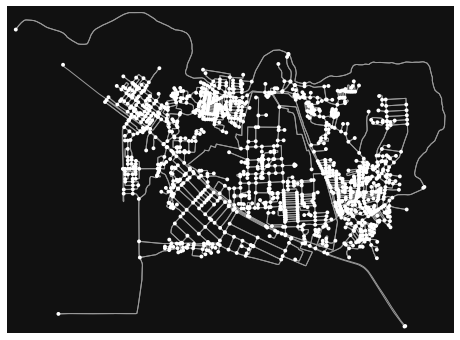

In [15]:
G = ox.graph_from_xml('/home/farhan/catkin_ws/autonomous-delivery-robot/Planning/Vnit_map/nitmap.osm', simplify = True)
#origin = ox.distance.nearest_nodes(map_graph,150, 150)
#print(map_graph)
# node_id=list(G.nodes())[35]
# G.nodes[node_id]['x'] #lon
# G.nodes[node_id]['y']

node_id=list(G.nodes())[130]
G.nodes[node_id]['y']

#destination = list(map_graph.nodes())[0]
#print(destination)
fig, ax = ox.plot_graph(map_graph)

In [41]:
# This function follows the predecessor
# backpointers and generates the equivalent path from the
# origin as a list of vertex keys.
def get_path(origin_key, goal_key, predecessors):
    key = goal_key
    path = [goal_key]
    
    while (key != origin_key):
        key = predecessors[key]
        path.insert(0, key)
        
    return path

Distance Heuristic Function

In [42]:
def distance_heuristic(state_key, goal_key, node_data):
    
    n1 = node_data[state_key]
    n2 = node_data[goal_key]
    
    #To find longitude and latitude of vertices
    
    long1 = n1['x']*math.pi/180
    lat1 = n1['y']*math.pi/180
    long2 = n2['x']*math.pi/180
    lat2 = n2['y']*math.pi/180
    
    # Use a spherical approximation of the earth for
    # estimating the distance between two points.
    r = 6371000
    x1 = r*math.cos(lat1)*math.cos(long1)
    y1 = r*math.cos(lat1)*math.sin(long1)
    z1 = r*math.sin(lat1)

    x2 = r*math.cos(lat2)*math.cos(long2)
    y2 = r*math.cos(lat2)*math.sin(long2)
    z2 = r*math.sin(lat2)

    d = ((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)**0.5
    
    return d

A* function

In [43]:
def A_star(origin_key, goal_key, graph):
    
    # min heap for open vertices
    open_queue = priority_dict.priority_dict({})
    #closed dictionary
    closed_dict = {}
    #predecessor dictionary
    predecessors = {}
    #best cost of each vertices
    costs = {}
    
    #get spatial data of nodes
    node_data = graph.nodes(True)
    
    costs[origin_key] = 0.0
    open_queue[origin_key] = distance_heuristic(origin_key, goal_key, node_data)
    
    #iterate through open_queue through all nodes till goal is found
    goal_found = False
    while (open_queue):
        # pop the initial vertex
        u, u_heu = open_queue.pop_smallest()
        u_cost = costs[u]
        # check condition if the start vertex is goal
        if u == goal_key:
            goal_found = True
            break
            
        for edge in graph.out_edges([u], data = True):
            # out_edges provide information about the edges. 
            #The return value of this is a list of tuples, each of which represent an outgoing edge. 
            #The second element of each tuple is the outgoing vertex at the other end of the edge.
            
            v = edge[1]          
            
            if v in closed_dict:
                continue
            
            uv_cost = edge[2]['length']
            
            if v not in open_queue:
                costs[v] = u_cost + uv_cost
                open_queue[v] = u_cost + uv_cost + distance_heuristic(v, goal_key, node_data)
                predecessors[v] = u
            else:
                v_cost = costs[v]
                if u_cost + uv_cost + distance_heuristic(v, goal_key, node_data) < v_cost:
                    open_queue[v] = u_cost + uv_cost + distance_heuristic(v, goal_key, node_data)
                    costs[v] = u_cost + uv_cost
                    predecessors[v] = u
                    
            closed_dict[v] = -1
            
    # If we get through entire priority queue without finding the goal,
    # something is wrong.
    if not goal_found:
        raise ValueError("Goal not found in search.")
    
    # Construct the path from the predecessors dictionary.
    return get_path(origin_key, goal_key, predecessors)               
                
                
                
        
        
    
    
    
    

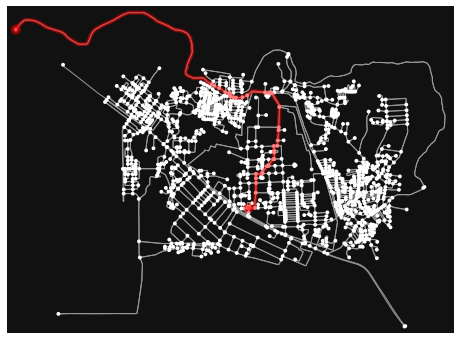

In [44]:
path = A_star(origin, destination, map_graph)        
fig, ax = ox.plot_graph_route(map_graph, path) 